# Linear Regression

In this tutorial we'll walk through how one can implement *linear regression* using MXNet APIs.

The function we are trying to learn is: *y = x<sub>1</sub>  +  2x<sub>2</sub>*, where *(x<sub>1</sub>,x<sub>2</sub>)* are input features and *y* is the corresponding label.

## Prerequisites

To complete this tutorial, we need:

- MXNet. See the instructions for your operating system in [Setup and Installation](http://mxnet.io/install/index.html).

- [Jupyter Notebook](http://jupyter.org/index.html).

```
$ pip install jupyter
```

To begin, the following code imports the necessary packages we'll need for this exercise.

In [1]:
import mxnet as mx
import numpy as np

# Fix the random seed
mx.random.seed(42)

import logging
logging.getLogger().setLevel(logging.DEBUG)

## Preparing the Data

In MXNet, data is input via **Data Iterators**. Here we will illustrate
how to encode a dataset into an iterator that MXNet can use. The data used in the example is made up of 2D data points with corresponding integer labels.

In [2]:
#Training data
train_data = np.random.uniform(0, 1, [100, 2])
train_label = np.array([train_data[i][0] + 2 * train_data[i][1] for i in range(100)])
batch_size = 1

#Evaluation Data
eval_data = np.array([[7,2],[6,10],[12,2]])
eval_label = np.array([11,26,16])

Once we have the data ready, we need to put it into an iterator and specify
parameters such as `batch_size` and `shuffle`. `batch_size` specifies the number
of examples shown to the model each time we update its parameters and `shuffle`
tells the iterator to randomize the order in which examples are shown to the model.

In [3]:
train_iter = mx.io.NDArrayIter(train_data, train_label, batch_size, shuffle=True, label_name='lin_reg_label')
eval_iter = mx.io.NDArrayIter(eval_data, eval_label, batch_size, shuffle=False, label_name='lin_reg_label')

In the above example, we have made use of `NDArrayIter`, which is useful for iterating
over both numpy ndarrays and MXNet NDArrays. In general, there are different types of iterators in
MXNet and you can use one based on the type of data you are processing.
Documentation for iterators can be found [here](http://mxnet.io/api/python/io/io.html).

## MXNet Classes

1. **IO:** The IO class as we already saw works on the data and carries out
   operations such as feeding data in batches and shuffling.

2. **Symbol:** The actual MXNet neural network is composed using symbols. MXNet has
   different types of symbols, including variable placeholders for input data,
   neural network layers, and operators that manipulate NDArrays.

3. **Module:** The module class in MXNet is used to define the overall computation.
	It is initialized with the model we want to train, the training inputs (data and labels)
	and some additional parameters such as learning rate and the optimization
	algorithm to use.

## Defining the Model

MXNet uses **Symbols** for defining a model. Symbols are the building blocks
and make up various components of the model. Symbols are used to define:

1. **Variables:** A variable is a placeholder for future data. This symbol is used
   to define a spot which will be filled with training data/labels in the future
   when we commence training.
2. **Neural Network Layers:** The layers of a network or any other type of model are
   also defined by Symbols. Such a symbol takes one or more previous symbols as
   inputs, performs some transformations on them, and creates one or more outputs.
   One such example is the `FullyConnected` symbol which specifies a fully connected
   layer of a neural network.
3. **Outputs:** Output symbols are MXNet's way of defining a loss. They are
   suffixed with the word "Output" (eg. the `SoftmaxOutput` layer). You can also
   [create your own loss function](https://github.com/dmlc/mxnet/blob/master/docs/tutorials/r/CustomLossFunction.md#how-to-use-your-own-loss-function).
   Some examples of existing losses are: `LinearRegressionOutput`, which computes
   the l2-loss between it's input symbol and the labels provided to it;
   `SoftmaxOutput`, which computes the categorical cross-entropy.

The ones described above and other symbols are chained together with the output of
one symbol serving as input to the next to build the network topology. More information
about the different types of symbols can be found [here](http://mxnet.io/api/python/symbol/symbol.html).

In [4]:
X = mx.sym.Variable('data')
Y = mx.symbol.Variable('lin_reg_label')
fully_connected_layer  = mx.sym.FullyConnected(data=X, name='fc1', num_hidden = 1)
lro = mx.sym.LinearRegressionOutput(data=fully_connected_layer, label=Y, name="lro")

The above network uses the following layers:

1. `FullyConnected`: The fully connected symbol represents a fully connected layer
   of a neural network (without any activation being applied), which in essence,
   is just a linear regression on the input attributes. It takes the following
   parameters:

   - `data`: Input to the layer (specifies the symbol whose output should be fed here)
   - `num_hidden`: Number of hidden neurons in the layer, which is same as the dimensionality
     of the layer's output

2. `LinearRegressionOutput`: Output layers in MXNet compute training loss, which is
	the measure of inaccuracy in the model's predictions. The goal of training is to minimize the
	training loss. In our example, the `LinearRegressionOutput` layer computes the *l2* loss against
	its input and the labels provided to it. The parameters to this layer are:

   - `data`: Input to this layer (specifies the symbol whose output should be fed here)
   - `label`: The training labels against which we will compare the input to the layer for calculation of l2 loss

**Note on naming convention:** the label variable's name should be the same as the
`label_name` parameter passed to your training data iterator. The default value of
this is `softmax_label`, but we have updated it to `lin_reg_label` in this
tutorial as you can see in `Y = mx.symbol.Variable('lin_reg_label')` and
`train_iter = mx.io.NDArrayIter(..., label_name='lin_reg_label')`.

Finally, the network is input to a *Module*, where we specify the symbol
whose output needs to be minimized (in our case, `lro` or the `lin_reg_output`), the
learning rate to be used while optimization and the number of epochs we want to
train our model for.

In [5]:
model = mx.mod.Module(
    symbol = lro ,
    data_names=['data'],
    label_names = ['lin_reg_label']# network structure
)

We can visualize the network we created by plotting it:

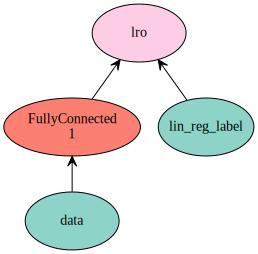

In [6]:
mx.viz.plot_network(symbol=lro, node_attrs={"shape":"oval","fixedsize":"false"})

## Training the model

Once we have defined the model structure, the next step is to train the
parameters of the model to fit the training data. This is accomplished using the
`fit()` function of the `Module` class.

In [7]:
model.fit(train_iter, eval_iter,
            optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
            num_epoch=20,
            eval_metric='mse',
            batch_end_callback = mx.callback.Speedometer(batch_size, 2))

INFO:root:Epoch[0] Batch [2]	Speed: 1679.40 samples/sec	mse=2.850075
INFO:root:Epoch[0] Batch [4]	Speed: 773.29 samples/sec	mse=4.386209
INFO:root:Epoch[0] Batch [6]	Speed: 831.87 samples/sec	mse=0.167490
INFO:root:Epoch[0] Batch [8]	Speed: 862.05 samples/sec	mse=0.909791
INFO:root:Epoch[0] Batch [10]	Speed: 725.53 samples/sec	mse=2.023573
INFO:root:Epoch[0] Batch [12]	Speed: 741.57 samples/sec	mse=0.438837
INFO:root:Epoch[0] Batch [14]	Speed: 859.22 samples/sec	mse=0.237353
INFO:root:Epoch[0] Batch [16]	Speed: 897.47 samples/sec	mse=0.082959
INFO:root:Epoch[0] Batch [18]	Speed: 1244.05 samples/sec	mse=0.097879
INFO:root:Epoch[0] Batch [20]	Speed: 1515.56 samples/sec	mse=0.644078
INFO:root:Epoch[0] Batch [22]	Speed: 1261.07 samples/sec	mse=0.090268
INFO:root:Epoch[0] Batch [24]	Speed: 1353.44 samples/sec	mse=0.428005
INFO:root:Epoch[0] Batch [26]	Speed: 1353.44 samples/sec	mse=0.145172
INFO:root:Epoch[0] Batch [28]	Speed: 1176.85 samples/sec	mse=0.521974
INFO:root:Epoch[0] Batch [30]	S

INFO:root:Epoch[2] Batch [32]	Speed: 2073.82 samples/sec	mse=0.000532
INFO:root:Epoch[2] Batch [34]	Speed: 2025.26 samples/sec	mse=0.003169
INFO:root:Epoch[2] Batch [36]	Speed: 1949.03 samples/sec	mse=0.006035
INFO:root:Epoch[2] Batch [38]	Speed: 1971.47 samples/sec	mse=0.002929
INFO:root:Epoch[2] Batch [40]	Speed: 2083.09 samples/sec	mse=0.013944
INFO:root:Epoch[2] Batch [42]	Speed: 2054.02 samples/sec	mse=0.016123
INFO:root:Epoch[2] Batch [44]	Speed: 2084.64 samples/sec	mse=0.000973
INFO:root:Epoch[2] Batch [46]	Speed: 2030.65 samples/sec	mse=0.023966
INFO:root:Epoch[2] Batch [48]	Speed: 2062.60 samples/sec	mse=0.021249
INFO:root:Epoch[2] Batch [50]	Speed: 1982.65 samples/sec	mse=0.006532
INFO:root:Epoch[2] Batch [52]	Speed: 2042.51 samples/sec	mse=0.023686
INFO:root:Epoch[2] Batch [54]	Speed: 2035.58 samples/sec	mse=0.001164
INFO:root:Epoch[2] Batch [56]	Speed: 2060.07 samples/sec	mse=0.009770
INFO:root:Epoch[2] Batch [58]	Speed: 2058.05 samples/sec	mse=0.004509
INFO:root:Epoch[2] B

INFO:root:Epoch[4] Batch [62]	Speed: 2083.09 samples/sec	mse=0.001801
INFO:root:Epoch[4] Batch [64]	Speed: 2047.00 samples/sec	mse=0.000202
INFO:root:Epoch[4] Batch [66]	Speed: 1977.98 samples/sec	mse=0.001980
INFO:root:Epoch[4] Batch [68]	Speed: 2056.54 samples/sec	mse=0.000053
INFO:root:Epoch[4] Batch [70]	Speed: 2058.05 samples/sec	mse=0.000727
INFO:root:Epoch[4] Batch [72]	Speed: 2020.86 samples/sec	mse=0.000907
INFO:root:Epoch[4] Batch [74]	Speed: 2088.80 samples/sec	mse=0.002744
INFO:root:Epoch[4] Batch [76]	Speed: 2041.52 samples/sec	mse=0.000348
INFO:root:Epoch[4] Batch [78]	Speed: 2105.57 samples/sec	mse=0.000011
INFO:root:Epoch[4] Batch [80]	Speed: 2038.54 samples/sec	mse=0.000749
INFO:root:Epoch[4] Batch [82]	Speed: 2086.20 samples/sec	mse=0.000754
INFO:root:Epoch[4] Batch [84]	Speed: 2014.07 samples/sec	mse=0.000746
INFO:root:Epoch[4] Batch [86]	Speed: 1620.67 samples/sec	mse=0.000526
INFO:root:Epoch[4] Batch [88]	Speed: 1895.30 samples/sec	mse=0.000871
INFO:root:Epoch[4] B

INFO:root:Epoch[6] Batch [94]	Speed: 1877.07 samples/sec	mse=0.000040
INFO:root:Epoch[6] Batch [96]	Speed: 1920.47 samples/sec	mse=0.000226
INFO:root:Epoch[6] Batch [98]	Speed: 1973.33 samples/sec	mse=0.000099
INFO:root:Epoch[6] Train-mse=0.000026
INFO:root:Epoch[6] Time cost=0.104
INFO:root:Epoch[6] Validation-mse=0.063365
INFO:root:Epoch[7] Batch [2]	Speed: 2122.62 samples/sec	mse=0.000069
INFO:root:Epoch[7] Batch [4]	Speed: 1892.31 samples/sec	mse=0.000045
INFO:root:Epoch[7] Batch [6]	Speed: 1969.16 samples/sec	mse=0.000024
INFO:root:Epoch[7] Batch [8]	Speed: 1648.70 samples/sec	mse=0.000051
INFO:root:Epoch[7] Batch [10]	Speed: 1913.02 samples/sec	mse=0.000141
INFO:root:Epoch[7] Batch [12]	Speed: 1986.88 samples/sec	mse=0.000127
INFO:root:Epoch[7] Batch [14]	Speed: 1534.97 samples/sec	mse=0.000013
INFO:root:Epoch[7] Batch [16]	Speed: 1901.32 samples/sec	mse=0.000000
INFO:root:Epoch[7] Batch [18]	Speed: 1923.99 samples/sec	mse=0.000006
INFO:root:Epoch[7] Batch [20]	Speed: 1915.64 sam

INFO:root:Epoch[9] Batch [26]	Speed: 1540.61 samples/sec	mse=0.000007
INFO:root:Epoch[9] Batch [28]	Speed: 1974.25 samples/sec	mse=0.000001
INFO:root:Epoch[9] Batch [30]	Speed: 1979.85 samples/sec	mse=0.000003
INFO:root:Epoch[9] Batch [32]	Speed: 2004.45 samples/sec	mse=0.000000
INFO:root:Epoch[9] Batch [34]	Speed: 1960.41 samples/sec	mse=0.000002
INFO:root:Epoch[9] Batch [36]	Speed: 2023.79 samples/sec	mse=0.000003
INFO:root:Epoch[9] Batch [38]	Speed: 1854.25 samples/sec	mse=0.000000
INFO:root:Epoch[9] Batch [40]	Speed: 2019.89 samples/sec	mse=0.000003
INFO:root:Epoch[9] Batch [42]	Speed: 1963.63 samples/sec	mse=0.000009
INFO:root:Epoch[9] Batch [44]	Speed: 2006.36 samples/sec	mse=0.000000
INFO:root:Epoch[9] Batch [46]	Speed: 1954.93 samples/sec	mse=0.000009
INFO:root:Epoch[9] Batch [48]	Speed: 2010.21 samples/sec	mse=0.000009
INFO:root:Epoch[9] Batch [50]	Speed: 1948.12 samples/sec	mse=0.000005
INFO:root:Epoch[9] Batch [52]	Speed: 2012.62 samples/sec	mse=0.000012
INFO:root:Epoch[9] B

INFO:root:Epoch[11] Batch [56]	Speed: 1594.79 samples/sec	mse=0.000000
INFO:root:Epoch[11] Batch [58]	Speed: 2031.63 samples/sec	mse=0.000000
INFO:root:Epoch[11] Batch [60]	Speed: 1290.16 samples/sec	mse=0.000001
INFO:root:Epoch[11] Batch [62]	Speed: 2053.51 samples/sec	mse=0.000001
INFO:root:Epoch[11] Batch [64]	Speed: 1889.33 samples/sec	mse=0.000000
INFO:root:Epoch[11] Batch [66]	Speed: 1981.25 samples/sec	mse=0.000001
INFO:root:Epoch[11] Batch [68]	Speed: 1987.35 samples/sec	mse=0.000000
INFO:root:Epoch[11] Batch [70]	Speed: 2036.56 samples/sec	mse=0.000000
INFO:root:Epoch[11] Batch [72]	Speed: 2046.00 samples/sec	mse=0.000000
INFO:root:Epoch[11] Batch [74]	Speed: 2002.05 samples/sec	mse=0.000001
INFO:root:Epoch[11] Batch [76]	Speed: 2077.93 samples/sec	mse=0.000000
INFO:root:Epoch[11] Batch [78]	Speed: 2075.36 samples/sec	mse=0.000000
INFO:root:Epoch[11] Batch [80]	Speed: 2053.51 samples/sec	mse=0.000000
INFO:root:Epoch[11] Batch [82]	Speed: 1996.81 samples/sec	mse=0.000000
INFO:r

INFO:root:Epoch[13] Batch [84]	Speed: 2087.24 samples/sec	mse=0.000000
INFO:root:Epoch[13] Batch [86]	Speed: 2100.83 samples/sec	mse=0.000000
INFO:root:Epoch[13] Batch [88]	Speed: 2084.13 samples/sec	mse=0.000000
INFO:root:Epoch[13] Batch [90]	Speed: 2107.16 samples/sec	mse=0.000000
INFO:root:Epoch[13] Batch [92]	Speed: 2081.54 samples/sec	mse=0.000000
INFO:root:Epoch[13] Batch [94]	Speed: 2125.31 samples/sec	mse=0.000000
INFO:root:Epoch[13] Batch [96]	Speed: 2119.94 samples/sec	mse=0.000000
INFO:root:Epoch[13] Batch [98]	Speed: 2090.88 samples/sec	mse=0.000000
INFO:root:Epoch[13] Train-mse=0.000000
INFO:root:Epoch[13] Time cost=0.103
INFO:root:Epoch[13] Validation-mse=0.000025
INFO:root:Epoch[14] Batch [2]	Speed: 2041.52 samples/sec	mse=0.000000
INFO:root:Epoch[14] Batch [4]	Speed: 2065.65 samples/sec	mse=0.000000
INFO:root:Epoch[14] Batch [6]	Speed: 2070.24 samples/sec	mse=0.000000
INFO:root:Epoch[14] Batch [8]	Speed: 2065.65 samples/sec	mse=0.000000
INFO:root:Epoch[14] Batch [10]	Sp

INFO:root:Epoch[16] Batch [10]	Speed: 2090.88 samples/sec	mse=0.000000
INFO:root:Epoch[16] Batch [12]	Speed: 2097.15 samples/sec	mse=0.000000
INFO:root:Epoch[16] Batch [14]	Speed: 2061.59 samples/sec	mse=0.000000
INFO:root:Epoch[16] Batch [16]	Speed: 2116.73 samples/sec	mse=0.000000
INFO:root:Epoch[16] Batch [18]	Speed: 2121.55 samples/sec	mse=0.000000
INFO:root:Epoch[16] Batch [20]	Speed: 2076.39 samples/sec	mse=0.000000
INFO:root:Epoch[16] Batch [22]	Speed: 2106.63 samples/sec	mse=0.000000
INFO:root:Epoch[16] Batch [24]	Speed: 2122.62 samples/sec	mse=0.000000
INFO:root:Epoch[16] Batch [26]	Speed: 2100.83 samples/sec	mse=0.000000
INFO:root:Epoch[16] Batch [28]	Speed: 2143.23 samples/sec	mse=0.000000
INFO:root:Epoch[16] Batch [30]	Speed: 2105.05 samples/sec	mse=0.000000
INFO:root:Epoch[16] Batch [32]	Speed: 2128.55 samples/sec	mse=0.000000
INFO:root:Epoch[16] Batch [34]	Speed: 2104.52 samples/sec	mse=0.000000
INFO:root:Epoch[16] Batch [36]	Speed: 2122.62 samples/sec	mse=0.000000
INFO:r

INFO:root:Epoch[18] Batch [38]	Speed: 2060.58 samples/sec	mse=0.000000
INFO:root:Epoch[18] Batch [40]	Speed: 2109.81 samples/sec	mse=0.000000
INFO:root:Epoch[18] Batch [42]	Speed: 2054.02 samples/sec	mse=0.000000
INFO:root:Epoch[18] Batch [44]	Speed: 2095.58 samples/sec	mse=0.000000
INFO:root:Epoch[18] Batch [46]	Speed: 2067.69 samples/sec	mse=0.000000
INFO:root:Epoch[18] Batch [48]	Speed: 2105.57 samples/sec	mse=0.000000
INFO:root:Epoch[18] Batch [50]	Speed: 2051.00 samples/sec	mse=0.000000
INFO:root:Epoch[18] Batch [52]	Speed: 1502.80 samples/sec	mse=0.000000
INFO:root:Epoch[18] Batch [54]	Speed: 2045.00 samples/sec	mse=0.000000
INFO:root:Epoch[18] Batch [56]	Speed: 2114.06 samples/sec	mse=0.000000
INFO:root:Epoch[18] Batch [58]	Speed: 2072.28 samples/sec	mse=0.000000
INFO:root:Epoch[18] Batch [60]	Speed: 2113.00 samples/sec	mse=0.000000
INFO:root:Epoch[18] Batch [62]	Speed: 2092.97 samples/sec	mse=0.000000
INFO:root:Epoch[18] Batch [64]	Speed: 2128.55 samples/sec	mse=0.000000
INFO:r

## Using a trained model: (Testing and Inference)

Once we have a trained model, we can do a couple of things with it - we can either
use it for inference or we can evaluate the trained model on test data. The latter is shown below:

In [8]:
model.predict(eval_iter).asnumpy()

array([[ 10.99987316],
       [ 25.99982834],
       [ 15.99978352]], dtype=float32)

We can also evaluate our model according to some metric. In this example, we are
evaluating our model's mean squared error (MSE) on the evaluation data.

In [9]:
metric = mx.metric.MSE()
mse = model.score(eval_iter, metric)
print("Achieved {0:.6f} validation MSE".format(mse[0][1]))
assert model.score(eval_iter, metric)[0][1] < 0.01001, "Achieved MSE (%f) is larger than expected (0.01001)" % model.score(eval_iter, metric)[0][1]

Achieved 0.000000 validation MSE


Let us try and add some noise to the evaluation data and see how the MSE changes:

In [10]:
eval_data = np.array([[7,2],[6,10],[12,2]])
eval_label = np.array([11.1,26.1,16.1]) #Adding 0.1 to each of the values
eval_iter = mx.io.NDArrayIter(eval_data, eval_label, batch_size, shuffle=False, label_name='lin_reg_label')
model.score(eval_iter, metric)

[('mse', 0.010034439464410147)]


We can also create a custom metric and use it to evaluate a model. More
information on metrics can be found in the [API documentation](http://mxnet.incubator.apache.org/api/python/metric/metric.html).

<!-- INSERT SOURCE DOWNLOAD BUTTONS -->
